<a href="https://colab.research.google.com/github/satyajitghana/TSAI-DeepNLP-END2.0/blob/main/10_Seq2Seq_Attention/Seq2Seq_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip3 install git+https://github.com/extensive-nlp/ttc_nlp --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 74 kB 2.4 MB/s 
     |████████████████████████████████| 6.4 MB 27.6 MB/s 
     |████████████████████████████████| 813 kB 45.8 MB/s 
     |████████████████████████████████| 234 kB 60.3 MB/s 
     |████████████████████████████████| 76 kB 4.8 MB/s 
     |████████████████████████████████| 636 kB 32.4 MB/s 
     |████████████████████████████████| 112 kB 68.6 MB/s 
     |████████████████████████████████| 10.6 MB 33.1 MB/s 
     |████████████████████████████████| 118 kB 61.0 MB/s 
     |████████████████████████████████| 829 kB 58.5 MB/s 
     |████████████████████████████████| 1.3 MB 49.2 MB/s 
     |████████████████████████████████| 621 kB 42.9 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 

In [2]:
import pytorch_lightning as pl

## Dataset

In [3]:
# PyTorch's Example Dataset's Code

import unicodedata
import string
import re
import random

import torch
import torchtext
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator, Vocab

from sklearn.model_selection import train_test_split

from urllib.request import urlopen

from io import BytesIO

from zipfile import ZipFile

from typing import *

UNK_token = 0
PAD_token = 1
SOS_token = 2
EOS_token = 3
MAX_LENGTH = 10

special_tokens = ['<unk>', '<pad>', '<sos>', '<eos>']

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def readPairs(langzip: ZipFile, lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = langzip.open(f'data/{lang1}-{lang2}.txt').read().decode('utf-8').strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]

    return pairs

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


def indexesFromSentence(lang: Vocab, sentence):
    return [lang.get_stoi()[word] for word in sentence.split(' ')]


def tensorFromSentence(lang: Vocab, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long)

def tensorsFromPair(lang1: Vocab, lang2: Vocab, pair):
    input_tensor = tensorFromSentence(lang1, pair[0])
    target_tensor = tensorFromSentence(lang2, pair[1])
    return (input_tensor, target_tensor)

class TorchLanguageData(pl.LightningDataModule):
    """
    DataModule for PyTorch Example Dataset, train, val, test splits and transforms
    Source: https://download.pytorch.org/tutorial/data.zip
    """

    name = "PyTorch example language dataset"
    zip_url = 'https://download.pytorch.org/tutorial/data.zip'

    def __init__(
        self,
        lang_file: str = 'eng-fra',
        reverse=True,
        val_split: float = 0.30,
        num_workers: int = 2,
        batch_size: int = 64,
        *args,
        **kwargs,
    ):
        """
        Args:
            data_dir: where to save/load the data
            val_split: how much the training pairs to use for the validation split, between (0 to 1)
            num_workers: how many workers to use for loading data
            normalize: If true applies image normalize
            batch_size: desired batch size.
        """
        super().__init__(*args, **kwargs)

        assert lang_file == 'eng-fra', 'eng-fra is the only choice for now, use `reverse=True` to get fra, eng pairs'

        self.val_split = val_split
        self.num_workers = num_workers
        self.batch_size = batch_size

        self.input_lang, self.output_lang, self.l_pairs = self.prepare_langs(lang_file, reverse)


    def prepare_langs(self, lang_file='eng-fra', reverse=True):
        with urlopen(self.zip_url) as f:
            with BytesIO(f.read()) as b, ZipFile(b) as datazip:
                lang1, lang2 = lang_file.split('-')
                pairs = readPairs(datazip, lang1, lang2, reverse)

        print("Read %s sentence pairs" % len(pairs))
        pairs = filterPairs(pairs)
        print("Trimmed to %s sentence pairs" % len(pairs))
        print("Counting words...")
        input_sentences, target_sentences = zip(*pairs)

        input_lang = build_vocab_from_iterator(
            [sentence.split(' ') for sentence in input_sentences],
            specials=special_tokens
        )

        output_lang = build_vocab_from_iterator(
            [sentence.split(' ') for sentence in target_sentences],
            specials=special_tokens
        )

        setattr(input_lang, 'name', lang2 if reverse else lang1)
        setattr(output_lang, 'name', lang1 if reverse else lang2)

        setattr(input_lang, 'n_words', len(input_lang))
        setattr(output_lang, 'n_words', len(output_lang))


        print("Counted words:")
        print(input_lang.name, input_lang.n_words)
        print(output_lang.name, output_lang.n_words)

        return input_lang, output_lang, pairs

    def prepare_data(self):
        """NOOP"""
        pass

    def setup(self, stage: Optional[str] = None):
        """Split the train and valid dataset"""
        print('splitting dataset into train and test"')
        self.train_pairs, self.val_pairs = train_test_split(self.l_pairs, test_size=self.val_split, random_state=69)

    def train_dataloader(self):
        loader = DataLoader(
            self.train_pairs,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
            collate_fn=self.collator_fn,
        )
        return loader

    def val_dataloader(self):
        loader = DataLoader(
            self.val_pairs,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            collate_fn=self.collator_fn,
        )
        return loader

    def test_dataloader(self):
        loader = DataLoader(
            self.val_pairs,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            collate_fn=self.collator_fn,
        )
        return loader



    @property
    def collator_fn(self):

        def wrapper(batch):
            raw_src, raw_tgt = zip(*batch)
            src_batch, tgt_batch = zip(*[tensorsFromPair(self.input_lang, self.output_lang, x) for x in batch])

            src_batch = torch.nn.utils.rnn.pad_sequence(src_batch, padding_value=PAD_token, batch_first=True)
            tgt_batch = torch.nn.utils.rnn.pad_sequence(tgt_batch, padding_value=PAD_token, batch_first=True)

            return src_batch, tgt_batch, raw_src, raw_tgt

        return wrapper

In [4]:
datamodule = TorchLanguageData(
    lang_file='eng-fra',
    reverse=True,
    batch_size=1
)

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4347
eng 2805


In [5]:
datamodule.setup()

splitting dataset into train and test"


In [6]:
train_loader = datamodule.train_dataloader()

In [7]:
datamodule.input_lang.get_stoi()['the']

2377

In [8]:
batch = next(iter(train_loader))

In [9]:
src_text, tgt_text, raw_src, raw_tgt = batch

In [10]:
src_text.shape, tgt_text.shape, len(raw_src), len(raw_tgt)

(torch.Size([1, 8]), torch.Size([1, 8]), 1, 1)

In [11]:
src_text[0], raw_src[0]

(tensor([  12,   19,   99,    9,   27, 1411,    4,    3]),
 'nous n allons pas le jeter .')

In [12]:
torch_dataset = datamodule

## Model

In [19]:
import torchtext
from tqdm.auto import tqdm
import torch
import torch.nn as nn

tqdm._instances.clear()

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, use_pretrained=False, vocab_itos=None):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        if use_pretrained and vocab_itos is None:
            raise ValueError('`use_pretained=True` with `vocab_itos=None`, please provide the vocab itos List')
        
        if use_pretrained:
            glove_vec = torchtext.vocab.GloVe(name='6B')
            glove_emb = glove_vec.get_vecs_by_tokens(vocab_itos)
            self.embedding = nn.Embedding.from_pretrained(glove_emb, padding_idx=PAD_token)
        else:
            self.embedding = nn.Embedding(input_size, hidden_size)

        assert self.embedding.embedding_dim == hidden_size,\
            f'hidden_size must equal embedding dim, found hidden_size={hidden_size}, embedding_dim={self.embedding.embedding_dim}'
        
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self, device):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self, device):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self, device):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import random

class TorchTranslateModel(pl.LightningModule):

    def __init__(self, hparams, vocab_itos=None, *args, **kwargs):
        super().__init__()

        self.save_hyperparameters(hparams)

        self.automatic_optimization = False

        if self.hparams.use_pretrained and vocab_itos is None:
            raise ValueError('`use_pretrained=True` with `vocab_itos=None`, please provide the vocab itos List')

        self.num_classes = self.hparams.output_dim

        self.encoder = EncoderRNN(
            self.hparams.input_dim,
            self.hparams.hidden_size
        )

        self.attn_decoder = AttnDecoderRNN(
            self.hparams.hidden_size,
            self.hparams.output_dim,
            dropout_p=self.hparams.dropout
        )

        self.criterion = nn.NLLLoss()


    def forward(self, input_tensor, target_tensor):
        encoder_hidden = self.encoder.initHidden(self.device)

        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)

        encoder_outputs = torch.zeros(self.hparams.max_length, self.encoder.hidden_size, device=self.device)

        loss = 0

        for ei in range(input_length):
            encoder_output, encoder_hidden = self.encoder(
                input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=self.device)

        decoder_hidden = encoder_hidden

        use_teacher_forcing = True if random.random() < self.hparams.teacher_forcing_ratio else False

        if use_teacher_forcing:
            # Teacher forcing: Feed the target as the next input
            for di in range(target_length):
                decoder_output, decoder_hidden, decoder_attention = self.attn_decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                loss += self.criterion(decoder_output, target_tensor[di])
                decoder_input = target_tensor[di]  # Teacher forcing

        else:
            # Without teacher forcing: use its own predictions as the next input
            for di in range(target_length):
                decoder_output, decoder_hidden, decoder_attention = self.attn_decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()  # detach from history as input

                loss += self.criterion(decoder_output, target_tensor[di])
                if decoder_input.item() == EOS_token:
                    break

        return loss, loss / target_length

    def shared_step(self, batch, batch_idx):
        src_tensor, tgt_tensor, raw_src, raw_tgt = batch

        if self.hparams.swap_langs:
            src_tensor, tgt_tensor = tgt_tensor, src_tensor
            raw_src, raw_tgt = raw_tgt, raw_src

        assert src_tensor.size(0) == 1, 'only batch_size==1 supported'
        assert tgt_tensor.size(0) == 1, 'only batch_size==1 supported'

        loss, loss_n = self(src_tensor.view(-1, 1), tgt_tensor.view(-1, 1))
        
        metric = {'loss': loss, 'loss_n': loss_n}

        return metric


    def training_step(self, batch, batch_idx):
        enc_opt, dec_opt = self.optimizers()
        enc_opt.zero_grad() ; dec_opt.zero_grad()

        metrics = self.shared_step(batch, batch_idx)

        self.manual_backward(metrics['loss'])

        enc_opt.step() ; dec_opt.step()

        log_metrics = {'train_loss': metrics['loss_n']}

        self.log_dict(log_metrics, prog_bar=True)

        return metrics


    def validation_step(self, batch, batch_idx):
        metrics = self.shared_step(batch, batch_idx)

        return metrics
    

    def validation_epoch_end(self, outputs):
        loss = torch.stack([x['loss_n'] for x in outputs]).mean()

        log_metrics = {'val_loss': loss}

        self.log_dict(log_metrics, prog_bar=True)

        return log_metrics


    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)

    def test_epoch_end(self, outputs):
        accuracy = torch.stack([x['loss_n'] for x in outputs]).mean()

        self.log('hp_metric', accuracy)

        self.log_dict({'test_loss': accuracy}, prog_bar=True)


    def configure_optimizers(self):
        encoder_optimizer = optim.SGD(self.encoder.parameters(), lr=self.hparams.enc_lr)
        decoder_optimizer = optim.SGD(self.attn_decoder.parameters(), lr=self.hparams.dec_lr)
        return encoder_optimizer, decoder_optimizer

    def evaluate(self, datamodule: TorchLanguageData, sentence):
        self.eval()

        input_lang, output_lang = datamodule.input_lang, datamodule.output_lang

        if self.hparams.swap_langs:
            input_lang, output_lang = output_lang, input_lang

        with torch.no_grad():
            input_tensor = tensorFromSentence(input_lang, sentence)
            input_length = input_tensor.size()[0]
            encoder_hidden = self.encoder.initHidden(self.device)

            max_length = self.hparams.max_length

            encoder_outputs = torch.zeros(max_length, self.encoder.hidden_size, device=self.device)

            for ei in range(input_length):
                encoder_output, encoder_hidden = self.encoder(input_tensor[ei],
                                                        encoder_hidden)
                encoder_outputs[ei] += encoder_output[0, 0]

            decoder_input = torch.tensor([[SOS_token]], device=self.device)  # SOS

            decoder_hidden = encoder_hidden

            decoded_words = []
            decoder_attentions = torch.zeros(max_length, max_length)

            for di in range(max_length):
                decoder_output, decoder_hidden, decoder_attention = self.attn_decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                decoder_attentions[di] = decoder_attention.data
                topv, topi = decoder_output.data.topk(1)
                if topi.item() == EOS_token:
                    decoded_words.append('<EOS>')
                    break
                else:
                    decoded_words.append(output_lang.get_itos()[topi.item()])

                decoder_input = topi.squeeze().detach()

            return decoded_words, decoder_attentions[:di + 1]

In [21]:
from omegaconf import OmegaConf

In [22]:
# input_lang = French
# output lang = English
# but we swap them in our model
# our model takes in English and gives French translation

hparams = OmegaConf.create({
    'input_dim': torch_dataset.output_lang.n_words, # we swap input and output lang
    'use_pretrained': True,
    'hidden_size': 300,
    'output_dim': torch_dataset.input_lang.n_words,
    'max_length': 10,
    'swap_langs': True,
    'teacher_forcing_ratio': 0.5,
    'dropout': 0.1,
    'enc_lr': 1e-2,
    'dec_lr': 1e-2,
    'epochs': 5,
})

In [58]:
torch_model = TorchTranslateModel(hparams, torch_dataset.input_lang.get_itos())

In [59]:
trainer = pl.Trainer(gpus=1, max_epochs=hparams.epochs)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [60]:
trainer.fit(torch_model, torch_dataset)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type           | Params
------------------------------------------------
0 | encoder      | EncoderRNN     | 1.4 M 
1 | attn_decoder | AttnDecoderRNN | 3.3 M 
2 | criterion    | NLLLoss        | 0     
------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.896    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [61]:
def evalulate_randomly(model, dataset, n=10):
    for i in range(n):
        input_sentence, output_sentence = random.choice(dataset.train_pairs)
        if hparams.swap_langs:
            input_sentence, output_sentence = output_sentence, input_sentence
        print('>', input_sentence)
        print('=', output_sentence)
        output_words, attentions = model.evaluate(dataset, input_sentence)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [62]:
evalulate_randomly(torch_model, torch_dataset)

> he s not going .
= il ne s y rend pas .
< il ne s y y . <EOS>

> we re not happy .
= nous ne sommes pas heureuses .
< nous ne sommes pas heureux . <EOS>

> we re too old .
= nous sommes trop vieux .
< nous sommes trop vieux . <EOS>

> i m not a crook .
= je ne suis pas un escroc .
< je ne suis pas un . <EOS>

> you re free of all responsibility .
= vous etes liberee de toute responsabilite .
< vous etes liberee de toute responsabilite . <EOS>

> i m sorry we re completely sold out .
= je suis desole nous avons ete devalises .
< je suis desole nous avons tout vendu . <EOS>

> you are the one .
= vous etes l elu .
< vous etes celui la . <EOS>

> they re all dead .
= elles sont toutes mortes .
< ils sont tous des . <EOS>

> he s always late for school .
= il est toujours en retard a l ecole .
< il est toujours en retard a l ecole . <EOS>

> he is busy .
= il a a faire .
< il a l l l l <EOS>



In [63]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
sns.set()
sns.set_style("dark")

def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(model, dataset, input_sentence):
    output_words, attentions = model.evaluate(dataset, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

input = i m very impressed by your work .
output = je suis tres par par votre travail . <EOS>


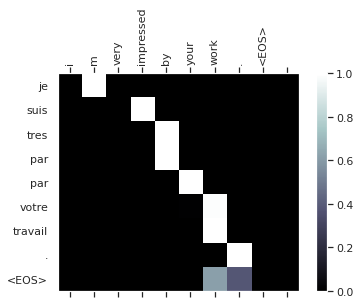

In [64]:
evaluateAndShowAttention(torch_model, torch_dataset, 'i m very impressed by your work .')

input = we re smart .
output = nous sommes intelligents . <EOS>


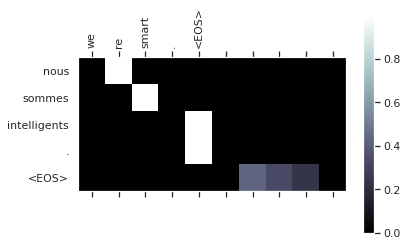

In [65]:
evaluateAndShowAttention(torch_model, torch_dataset, 'we re smart .')

input = i m still hungry .
output = j ai toujours faim . <EOS>


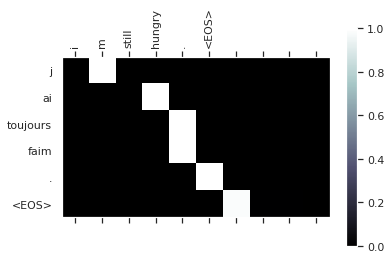

In [66]:
evaluateAndShowAttention(torch_model, torch_dataset, 'i m still hungry .')

input = he is very eager to go there .
output = il est tres sensible de partir . <EOS>


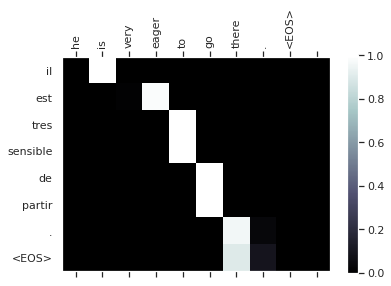

In [67]:
evaluateAndShowAttention(torch_model, torch_dataset, 'he is very eager to go there .')

input = i m sorry we re completely sold out .
output = je suis desole nous avons tout vendu . <EOS>


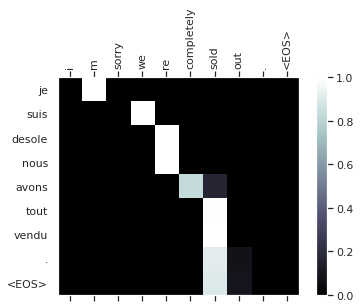

In [68]:
evaluateAndShowAttention(torch_model, torch_dataset, 'i m sorry we re completely sold out .')